# Universidad de Buenos Aires
# Deep Learning - TP2
# Alumno: Matias Werbin

## Parte 2.a

Implemente una arquitectura de red neuronal basada en CNN para identificar del dataset fashion MNIST las 10 clases del mismo. Sobre dicho modelo, realize una exploración de 5 variantes distintas (que se desprenden del modelo propuesto) variando alguno (o varios) de los siguientes hiperparámetros
- numero de capas.
- numero de kernels.
- tamaño de kernels.


a) Evalue la evolución de la función de perdida y la accuracy (para train y test) para cada modelo y elija el que considera mejor.

b) Al mejor modelo, aplique capas de dropout para ver si puede mejorar sus métricas.

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
from tqdm import tqdm # <- para graficar la barra de avance
from sklearn.metrics import f1_score

In [ ]:
# Descarga set de entrenamento de FashionMINIST.
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)

# Descarga set de entrenamiento de FashionMINIST.
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)

100%|██████████| 26421880/26421880 [00:03<00:00, 7768462.97it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 125808.83it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2226627.24it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4990126.41it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



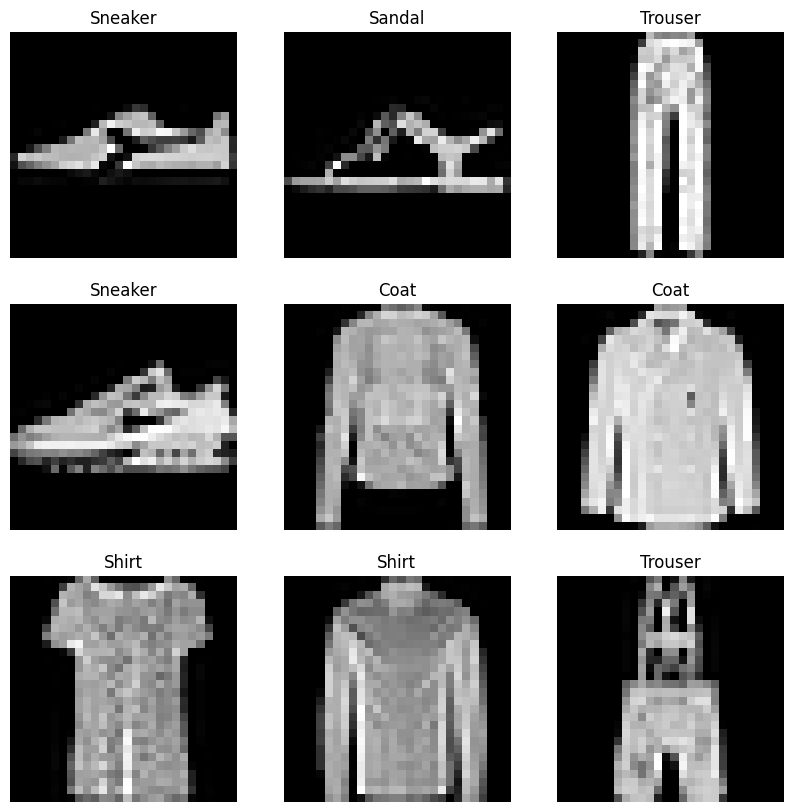

In [ ]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [ ]:
# Creamos DataLoader
dataloader = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)}

In [ ]:
# Verificamos dimensiones de los batch del Dataloader
train_features, train_labels = next(iter(dataloader['train']))
print(f"Tamaño del batch de feature (input / imagen): {train_features.shape}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.shape}")

Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([64])


Shape de una imagen tomada al azar :  torch.Size([1, 28, 28])
Shape imagen DESPUES de squeeze:  torch.Size([28, 28])


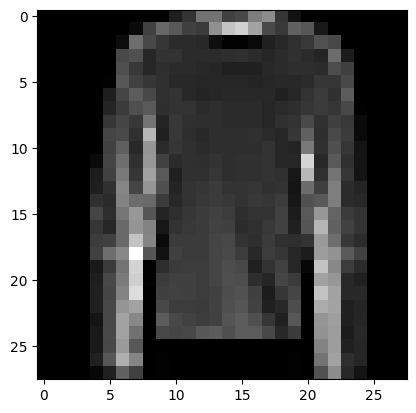

Label 2 = Pullover


In [ ]:
# Tomamos una img al azar, verificamos dimensiones y visualizamos

img = train_features[22]
print('Shape de una imagen tomada al azar : ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('Shape imagen DESPUES de squeeze: ', img.shape)
label = train_labels[22]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label {label} = {labels_map[label.item()]}")

In [ ]:
# Incializamos device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#Creación de funcion de entrenamiento y evaluación

def fit_eval(model,dataloader,epochs,file_name=None):
  model.to(device)
  optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
  criteria=torch.nn.CrossEntropyLoss()
  epoch_train_loss=[]
  epoch_test_loss=[]
  epoch_train_f1= []
  epoch_test_f1=[]

  for epoch in range(1,epochs+1):
    model.train()
    train_loss=[]
    train_f1=[]
    bar=tqdm(dataloader['train'])
    for batch in bar:
      X_train,y_train=batch
      X_train=X_train.to(device)
      y_train=y_train.to(device)
      optimizer.zero_grad()
      y_hat=model(X_train)
      loss=criteria(y_hat,y_train)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
      f1_train = f1_score(y_train.cpu().numpy(), torch.argmax(y_hat, axis=1).cpu().numpy(), average='weighted')
      train_f1.append(f1_train)
      bar.set_description(f"loss{np.mean(train_loss):.5f} F1 {np.mean(train_f1):.5f}")

    epoch_train_loss.append(np.mean(train_loss))
    epoch_train_f1.append(np.mean(train_f1))

    test_loss=[]
    test_f1=[]
    bar=tqdm(dataloader['test'])
    model.eval()
    with torch.no_grad():
      for batch in bar:
        X_test,y_test= batch
        X_test=X_test.to(device)
        y_tes=y_test.to(device)
        y_hat=model(X_test)
        loss=criteria(y_hat,y_test)
        test_loss.append(loss.item())
        f1_test=f1_score(y_test.cpu().numpy(), torch.argmax(y_hat, axis=1).cpu().numpy(), average='weighted')
        test_f1.append(f1_test)
        bar.set_description(f"loss{np.mean(test_loss):.5f} F1 {np.mean(test_f1):.5f}")

    epoch_test_loss.append(np.mean(np.mean(test_loss)))
    epoch_test_f1.append(np.mean(test_f1))
    print(f"Epoch {epoch}/{epochs} train_loss {np.mean(train_loss):.5f} test_loss {np.mean(test_loss):.5f} f1_train {np.mean(train_f1):.5f} f1_test {np.mean(test_f1):.5f}")

  plt.figure()
  plt.plot(range(1, len(epoch_train_loss) + 1), epoch_train_loss, 'r')
  plt.plot(range(1, len(epoch_test_loss) + 1), epoch_test_loss, 'black')
  plt.title('Train/Test Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Train Loss', 'Test Loss'])
  plt.xticks(range(1, max(len(epoch_train_loss), len(epoch_test_loss)) + 1))

  plt.figure()
  plt.plot(range(1,len(epoch_train_f1) + 1) , epoch_train_f1,'r')
  plt.plot(range(1,len(epoch_test_f1)+1),epoch_test_f1,'black')
  plt.title('Train/Test F1')
  plt.xlabel('Epochs')
  plt.ylabel("F1")
  plt.legend(['F1 Train','F1 Test'])
  plt.xticks(range(1, max(len(epoch_train_loss), len(epoch_test_loss)) + 1))
  plt.grid()

  # Guardar el modelo solo si se proporciona un file_name
  if file_name:
    save_path = '/content/' + file_name
    torch.save(model.state_dict(), save_path)
    print(f'Modelo entrenadom evaluado y guardado en {save_path}')
  else:
        print('Modelo entrenado y evaluado.')


Primer Arquitectura:

1) Dos Conv Layer formada:
* Capa Convulucional(estrategia padding=same, kernel 7x7, stride=1)
* Capa No Lineal ReLU
* Capa Pooling (estrategia Max, kernel 3x3, stride=2, padding=1)

2) Fully Connected compuesta por una capa lineal con 10 salidas una para cada clase





In [ ]:
# Construcción de Layer de convolución

def conv_layer(c_in, c_out, k=7, p='same', s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp))

In [ ]:
# Arquitectura CNN_1

class CNN_1(torch.nn.Module):
  def __init__(self,in_channels=1, outputs=10): # el in_channels es 1 porque las imagenes son escala de grises y outputs es 10 porque tenemos 10 clases
    super().__init__()
    self.conv1=conv_layer(in_channels,16)
    self.conv1_out = None
    self.conv2=conv_layer(16,32)
    self.conv2_out = None
    self.fc=torch.nn.Linear(1568,outputs)


  def forward(self,x):
    self.conv1_out=self.conv1(x)
    self.conv2_out=self.conv2(self.conv1_out)
    x=self.conv2_out.view(self.conv2_out.shape[0],-1)
    x=self.fc(x)

    return x


In [ ]:
# Inicialización CNN_1
model_1=CNN_1()

In [ ]:
# Revisamos summary
summary(model_1,(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             800
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          25,120
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                   [-1, 10]          15,690
Total params: 41,610
Trainable params: 41,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.16
Estimated Total Size (MB): 0.48
----------------------------------------------------------------


loss0.42618 F1 0.83846: 100%|██████████| 157/157 [00:07<00:00, 19.80it/s]


Epoch 1/5 loss 0.51207 test_loss 0.42618 f1_train 0.80930 f1_test 0.83846


loss0.31363 F1 0.88842: 100%|██████████| 157/157 [00:06<00:00, 23.32it/s]


Epoch 2/5 loss 0.32885 test_loss 0.31363 f1_train 0.88026 f1_test 0.88842


loss0.30488 F1 0.88946: 100%|██████████| 157/157 [00:07<00:00, 19.94it/s]


Epoch 3/5 loss 0.28183 test_loss 0.30488 f1_train 0.89661 f1_test 0.88946


loss0.30618 F1 0.88629: 100%|██████████| 157/157 [00:07<00:00, 22.11it/s]


Epoch 4/5 loss 0.25679 test_loss 0.30618 f1_train 0.90672 f1_test 0.88629


loss0.29738 F1 0.89101: 100%|██████████| 157/157 [00:15<00:00,  9.95it/s]


Epoch 5/5 loss 0.24014 test_loss 0.29738 f1_train 0.91151 f1_test 0.89101
Model saved to /content/cnn_1_5epochs.pth


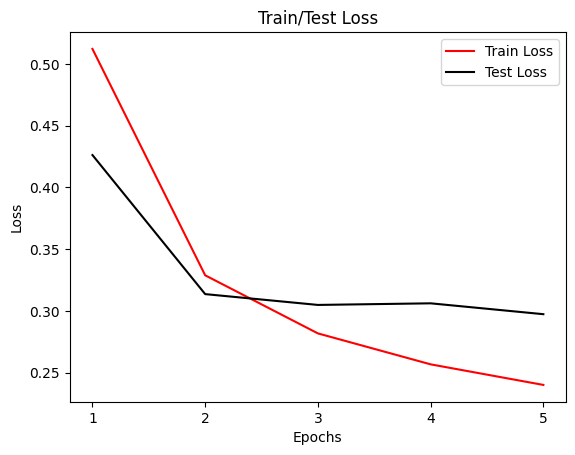

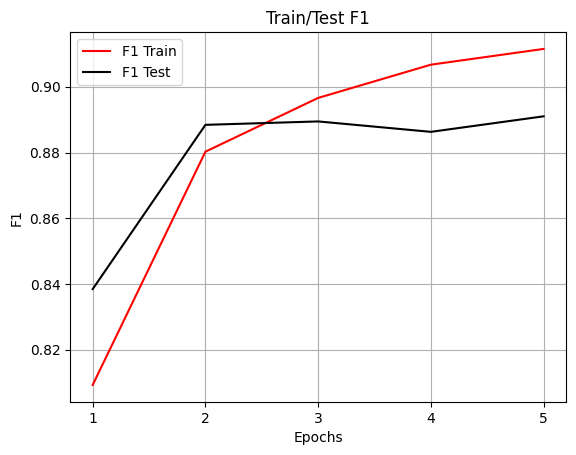

In [ ]:
# Fitteo y evaluacion de model 1 (Si desea guardar el modelo en .pth completar argumento file_name)
fit_eval(model_1,dataloader,epochs=5)

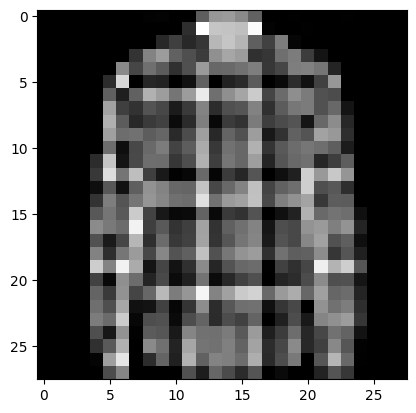

Shape imagen de entrada a red:  torch.Size([1, 1, 28, 28])
Predición del modelo:
tensor([[-2.5467, -2.9191, -0.3803, -1.7883,  1.7870, -7.3578,  4.6473, -9.8118,
         -2.9056, -8.1072]])

Softmax de predicción:
tensor([[7.0376e-04, 4.8494e-04, 6.1414e-03, 1.5024e-03, 5.3646e-02, 5.7279e-06,
         9.3702e-01, 4.9231e-07, 4.9152e-04, 2.7072e-06]])

El numero predicho es un 6(label real es 6) y corresponde a Shirt


In [ ]:
# Probamos como clasifica con un elemento

test_features, test_labels = next(iter(dataloader['test']))

# item a usar k
k = 7
img_sample=test_features[7]

# ploteo la imagen
plt.imshow(img_sample.squeeze(), cmap='gray')
plt.show()

# Armar sample en formato que pueda procesar la cnn (batch_size, n_chanells, h, w)
samp_imp = img_sample.unsqueeze(0)
samp_img = img_sample.unsqueeze(0).to(device)
print('Shape imagen de entrada a red: ', samp_img.shape)

# Pasar sample al modelo
# model_1.cuda()
model_1.eval()
y_hat = model_1(samp_img)
print('Predición del modelo:')
print(y_hat.detach())
print()
print('Softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1).detach())
print()
print(f'El numero predicho es un {torch.argmax(y_hat, axis=1).item()}(label real es {test_labels[7]}) y corresponde a {labels_map[torch.argmax(y_hat, axis=1).item()]}')

Segunda Arquitectura:

1) Tres Conv Layer formada:
* Capa Convulucional(estrategia padding=same, kernel 5x5, stride=1)
* Capa No Lineal ReLU
* Capa Pooling (estrategia Max, kernel 3x3, stride=2,padding=1)

2) Fully Connected compuesta por una capa lineal con 10 salidas una para cada clase

In [ ]:
# Arquitectura CNN_2

class CNN_2(torch.nn.Module):
  def __init__(self,in_channels=1, outputs=10): # el in_channels es 1 porque las imagenes son escala de grises y outputs es 10 porque tenemos 10 clases
    super().__init__()
    self.conv1=conv_layer(in_channels,16,k=5)
    self.conv1_out = None
    self.conv2=conv_layer(16,32,k=5)
    self.conv2_out = None
    self.conv3=conv_layer(32,64,k=5)
    self.conv3_out = None
    self.fc=torch.nn.Linear(1024,outputs)


  def forward(self,x):
    self.conv1_out=self.conv1(x)
    self.conv2_out=self.conv2(self.conv1_out)
    self.conv3_out=self.conv3(self.conv2_out)
    x=self.conv3_out.view(self.conv3_out.shape[0],-1)
    x=self.fc(x)

    return x

In [ ]:
# Inicialización CNN_2
model_2=CNN_2()

In [ ]:
# Revisamos summary
summary(model_2,(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          12,832
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          51,264
              ReLU-8             [-1, 64, 7, 7]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                   [-1, 10]          10,250
Total params: 74,762
Trainable params: 74,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.29
Estimated Tot

loss0.37590 F1 0.86070: 100%|██████████| 157/157 [00:08<00:00, 18.47it/s]


Epoch 1/5 loss 0.52087 test_loss 0.37590 f1_train 0.80259 f1_test 0.86070


loss0.32118 F1 0.88214: 100%|██████████| 157/157 [00:11<00:00, 14.03it/s]


Epoch 2/5 loss 0.31666 test_loss 0.32118 f1_train 0.88184 f1_test 0.88214


loss0.31521 F1 0.88517: 100%|██████████| 157/157 [00:07<00:00, 20.42it/s]


Epoch 3/5 loss 0.26951 test_loss 0.31521 f1_train 0.90018 f1_test 0.88517


loss0.30428 F1 0.88537: 100%|██████████| 157/157 [00:15<00:00, 10.32it/s]


Epoch 4/5 loss 0.24299 test_loss 0.30428 f1_train 0.91018 f1_test 0.88537


loss0.24806 F1 0.90822: 100%|██████████| 157/157 [00:08<00:00, 18.19it/s]


Epoch 5/5 loss 0.22187 test_loss 0.24806 f1_train 0.91739 f1_test 0.90822
Model saved to /content/cnn_2_5epochs.pth


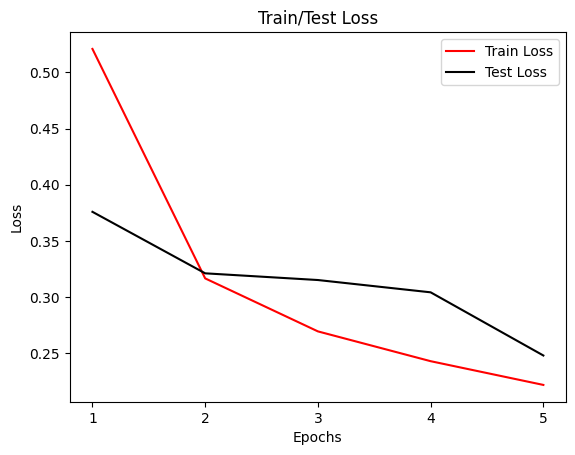

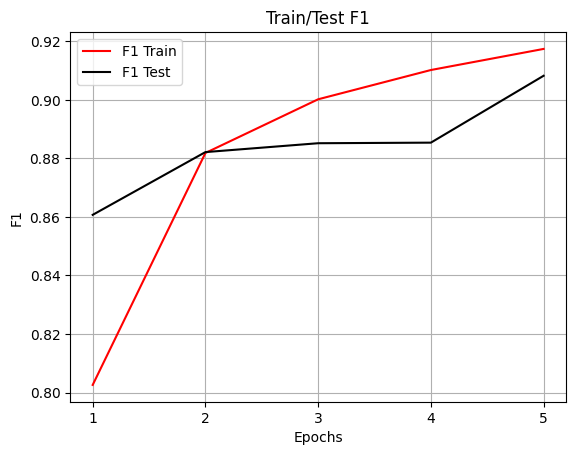

In [ ]:
# Fitteo y evaluacion de model 2 (Si desea guardar el modelo en .pth completar argumento file_name)
fit_eval(model_2,dataloader,epochs=5)

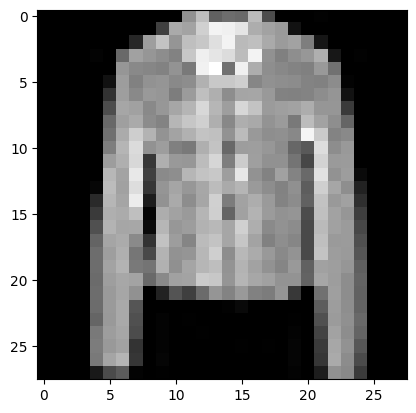

Shape imagen de entrada a red:  torch.Size([1, 1, 28, 28])
Predición del modelo:
tensor([[ -4.4788,  -6.8049,   0.5259,  -8.2862,   5.9844,  -6.4286,   1.6417,
         -11.1296,  -7.9451,  -4.2661]])

Softmax de predicción:
tensor([[2.8081e-05, 2.7428e-06, 4.1873e-03, 6.2359e-07, 9.8296e-01, 3.9962e-06,
         1.2779e-02, 3.6307e-08, 8.7706e-07, 3.4738e-05]])

El numero predicho es un 4(label real es 4) y corresponde a Coat


In [ ]:
# Probamos como clasifica con un elemento

test_features, test_labels = next(iter(dataloader['test']))

# item a usar k
k = 10
img_sample=test_features[10]

# ploteo la imagen
plt.imshow(img_sample.squeeze(), cmap='gray')
plt.show()

# Armar sample en formato que pueda procesar la cnn (batch_size, n_chanells, h, w)
samp_imp = img_sample.unsqueeze(0)
samp_img = img_sample.unsqueeze(0).to(device)
print('Shape imagen de entrada a red: ', samp_img.shape)

# Pasar sample al modelo
# model_2.cuda()
model_2.eval()
y_hat = model_2(samp_img)
print('Predición del modelo:')
print(y_hat.detach())
print()
print('Softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1).detach())
print()
print(f'El numero predicho es un {torch.argmax(y_hat, axis=1).item()}(label real es {test_labels[10]}) y corresponde a {labels_map[torch.argmax(y_hat, axis=1).item()]}')

Tercera Arquitectura:

1) 3 Conv Layer formada:
* Capa Convulucional(estrategia padding=same, kernel 3x3, stride=1)
* Capa No Lineal ReLU
* Capa Pooling (estrategia Max, kernel 3x3, stride=2)

2) 2 Conv Layer formada:
* Capa Convulucional(estrategia padding=same, kernel 3x3, stride=1)
* Capa No Lineal ReLU
* Capa Pooling (estrategia Avg, kernel 3x3, stride=2,padding=1)

3) Fully Connected compuesta por una capa lineal con 10 salidas una para cada clase

In [ ]:
# Modificación de funcion conv_layer: se modifica la capa de pooling a estrategia Average

def conv_layer_2(c_in, c_out, k=7, p='same', s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.AvgPool2d(pk, stride=ps, padding=pp))

In [ ]:
# Arquitectura CNN_3

class CNN_3(torch.nn.Module):
  def __init__(self,in_channels=1, outputs=10): # el in_channels es 1 porque las imagenes son escala de grises y outputs es 10 porque tenemos 10 clases
    super().__init__()
    self.conv1=conv_layer(in_channels,16, k=5)
    self.conv1_out = None
    self.conv2=conv_layer(16,32,k=3)
    self.conv2_out = None
    self.conv3=conv_layer(32,64,k=3)
    self.conv3_out = None
    self.conv4=conv_layer_2(64,128,k=3)
    self.conv4_out = None
    self.conv5=conv_layer_2(128,256,k=3)
    self.conv5_out = None
    self.fc=torch.nn.Linear(256,outputs)


  def forward(self,x):
    self.conv1_out=self.conv1(x)
    self.conv2_out=self.conv2(self.conv1_out)
    self.conv3_out=self.conv3(self.conv2_out)
    self.conv4_out=self.conv4(self.conv3_out)
    self.conv5_out=self.conv5(self.conv4_out)
    x=self.conv5_out.view(self.conv5_out.shape[0],-1)
    x=self.fc(x)

    return x

In [ ]:
# Inicialización CNN_3
model_3=CNN_3()

In [ ]:
# Revisamos summary
summary(model_3,(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          18,496
              ReLU-8             [-1, 64, 7, 7]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]          73,856
             ReLU-11            [-1, 128, 4, 4]               0
        AvgPool2d-12            [-1, 128, 2, 2]               0
           Conv2d-13            [-1, 256, 2, 2]         295,168
             ReLU-14            [-1, 25

loss0.54698 F1 0.78173: 100%|██████████| 157/157 [00:08<00:00, 18.28it/s]


Epoch 1/5 train_loss 0.80404 test_loss 0.54698 f1_train 0.66646 f1_test 0.78173


loss0.42446 F1 0.84208: 100%|██████████| 157/157 [00:07<00:00, 21.07it/s]


Epoch 2/5 train_loss 0.47993 test_loss 0.42446 f1_train 0.81550 f1_test 0.84208


loss0.36507 F1 0.86457: 100%|██████████| 157/157 [00:08<00:00, 18.39it/s]


Epoch 3/5 train_loss 0.38902 test_loss 0.36507 f1_train 0.85407 f1_test 0.86457


loss0.35232 F1 0.86856: 100%|██████████| 157/157 [00:07<00:00, 21.34it/s]


Epoch 4/5 train_loss 0.33548 test_loss 0.35232 f1_train 0.87483 f1_test 0.86856


loss0.31658 F1 0.88251: 100%|██████████| 157/157 [00:08<00:00, 18.88it/s]


Epoch 5/5 train_loss 0.30300 test_loss 0.31658 f1_train 0.88688 f1_test 0.88251
¿Desea guardar el modelo? (s/n): s
Modelo entrenado, evaluado y guardado en: /content/cnn_3_5epochs.pth


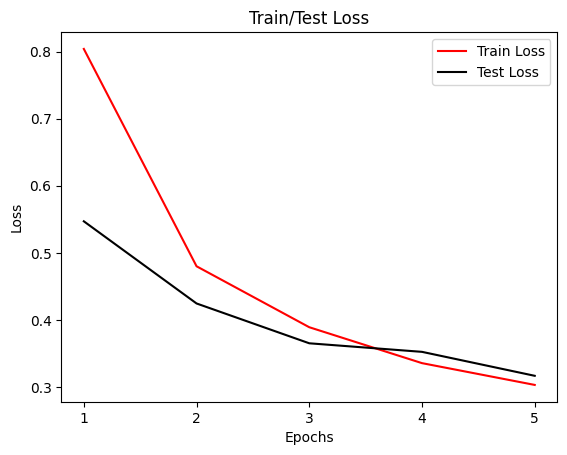

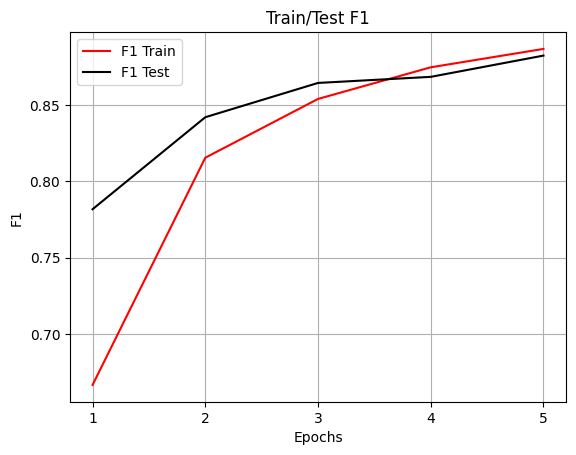

In [ ]:
# Fitteo y evaluacion de model 3 (Si desea guardar el modelo en .pth completar argumento file_name)
fit_eval(model_3,dataloader,epochs=5)

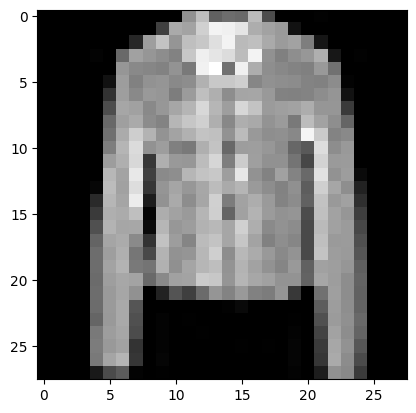

Shape imagen de entrada a red:  torch.Size([1, 1, 28, 28])
Predición del modelo:
tensor([[ -3.5600,  -5.6288,   3.5876,  -3.2779,   6.7121, -12.7462,   3.0049,
         -14.2055,  -4.6250, -12.6549]])

Softmax de predicción:
tensor([[3.2364e-05, 4.0886e-06, 4.1137e-02, 4.2910e-05, 9.3580e-01, 3.3154e-09,
         2.2969e-02, 7.7050e-10, 1.1157e-05, 3.6324e-09]])

El numero predicho es un 4(label real es 4) y corresponde a Coat


In [ ]:
# Probamos como clasifica con un elemento

test_features, test_labels = next(iter(dataloader['test']))

# item a usar k
k = 10
img_sample=test_features[k]

# ploteo la imagen
plt.imshow(img_sample.squeeze(), cmap='gray')
plt.show()

# Armar sample en formato que pueda procesar la cnn (batch_size, n_chanells, h, w)
samp_imp = img_sample.unsqueeze(0)
samp_img = img_sample.unsqueeze(0).to(device)
print('Shape imagen de entrada a red: ', samp_img.shape)

# Pasar sample al modelo
# model_3.cuda()
model_3.eval()
y_hat = model_3(samp_img)
print('Predición del modelo:')
print(y_hat.detach())
print()
print('Softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1).detach())
print()
print(f'El numero predicho es un {torch.argmax(y_hat, axis=1).item()}(label real es {test_labels[k]}) y corresponde a {labels_map[torch.argmax(y_hat, axis=1).item()]}')

Cuarta Arquitectura:

1) Tres Conv Layer formada:
* Capa Convulucional(estrategia padding=same, kernel 7x7, stride=1)
* Capa No Lineal TanH
* Capa Pooling (estrategia Max, kernel 5x5 en primera capa luego kernel 3x3, stride=2,padding=1)

2) Fully Connected compuesta por una capa lineal con 10 salidas una para cada clase

In [ ]:
# Modificación de funcion conv_layer: se modifica la capa no lineal a Tanh

def conv_layer_3(c_in, c_out, k=7, p='same', s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.Tanh(),
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp))

In [ ]:
# Arquitectura CNN_4

class CNN_4(torch.nn.Module):
  def __init__(self,in_channels=1, outputs=10): # el in_channels es 1 porque las imagenes son escala de grises y outputs es 10 porque tenemos 10 clases
    super().__init__()
    self.conv1=conv_layer_3(in_channels,16, k=7,pk=5)
    self.conv1_out = None
    self.conv2=conv_layer_3(16,32,k=7)
    self.conv2_out = None
    self.conv3=conv_layer_3(32,64,k=7)
    self.conv3_out = None
    self.fc=torch.nn.Linear(1024,outputs)


  def forward(self,x):
    self.conv1_out=self.conv1(x)
    self.conv2_out=self.conv2(self.conv1_out)
    self.conv3_out=self.conv3(self.conv2_out)
    x=self.conv3_out.view(self.conv3_out.shape[0],-1)
    x=self.fc(x)

    return x

In [ ]:
# Inicialización CNN_4
model_4=CNN_4()

In [ ]:
# Revisamos summary
summary(model_4,(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             800
              Tanh-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 13, 13]               0
            Conv2d-4           [-1, 32, 13, 13]          25,120
              Tanh-5           [-1, 32, 13, 13]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]         100,416
              Tanh-8             [-1, 64, 7, 7]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                   [-1, 10]          10,250
Total params: 136,586
Trainable params: 136,586
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 0.52
Estimated T

loss0.34641 F1 0.86729: 100%|██████████| 157/157 [00:09<00:00, 16.19it/s]


Epoch 1/5 train_loss 0.48442 test_loss 0.34641 f1_train 0.81505 f1_test 0.86729


loss0.33015 F1 0.88030: 100%|██████████| 157/157 [00:16<00:00,  9.71it/s]


Epoch 2/5 train_loss 0.32524 test_loss 0.33015 f1_train 0.87763 f1_test 0.88030


loss0.28694 F1 0.89441: 100%|██████████| 157/157 [00:10<00:00, 14.92it/s]


Epoch 3/5 train_loss 0.28451 test_loss 0.28694 f1_train 0.89340 f1_test 0.89441


loss0.27899 F1 0.89716: 100%|██████████| 157/157 [00:10<00:00, 14.75it/s]


Epoch 4/5 train_loss 0.26294 test_loss 0.27899 f1_train 0.90259 f1_test 0.89716


loss0.26618 F1 0.90556: 100%|██████████| 157/157 [00:10<00:00, 14.47it/s]


Epoch 5/5 train_loss 0.23850 test_loss 0.26618 f1_train 0.91223 f1_test 0.90556
¿Desea guardar el modelo? (s/n): s
Modelo entrenado, evaluado y guardado en: /content/cnn_4_5epochs.pth


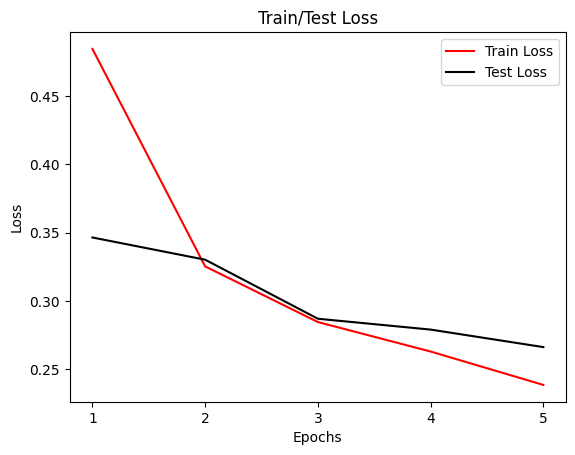

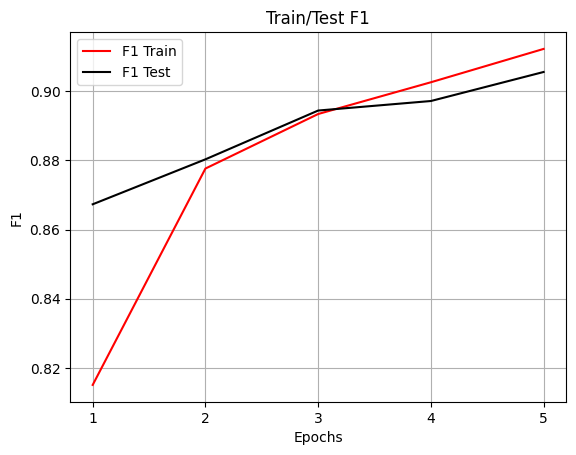

In [ ]:
# Fitteo y evaluacion de model 4 (Si desea guardar el modelo en .pth completar argumento file_name)
fit_eval(model_4,dataloader,epochs=5)

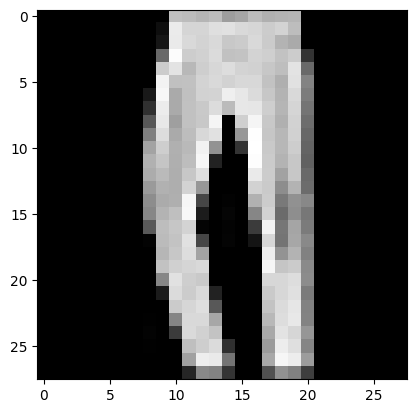

Shape imagen de entrada a red:  torch.Size([1, 1, 28, 28])
Predición del modelo:
tensor([[-0.5747, 17.0798,  0.8797,  0.8995,  4.6634, -8.7152,  0.4102, -8.0977,
         -1.2904, -6.4030]])

Softmax de predicción:
tensor([[2.1516e-08, 1.0000e+00, 9.2123e-08, 9.3970e-08, 4.0517e-06, 6.2712e-12,
         5.7609e-08, 1.1629e-11, 1.0518e-08, 6.3324e-11]])

El numero predicho es un 1(label real es 1) y corresponde a Trouser


In [ ]:
# Probamos como clasifica con un elemento

test_features, test_labels = next(iter(dataloader['test']))

# item a usar k
k = 5
img_sample=test_features[k]

# ploteo la imagen
plt.imshow(img_sample.squeeze(), cmap='gray')
plt.show()

# Armar sample en formato que pueda procesar la cnn (batch_size, n_chanells, h, w)
samp_imp = img_sample.unsqueeze(0)
samp_img = img_sample.unsqueeze(0).to(device)
print('Shape imagen de entrada a red: ', samp_img.shape)

# Pasar sample al modelo
# model_4.cuda()
model_4.eval()
y_hat = model_4(samp_img)
print('Predición del modelo:')
print(y_hat.detach())
print()
print('Softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1).detach())
print()
print(f'El numero predicho es un {torch.argmax(y_hat, axis=1).item()}(label real es {test_labels[k]}) y corresponde a {labels_map[torch.argmax(y_hat, axis=1).item()]}')

Quinta Arquitectura:

1) Tres Conv Layer formada:
* Capa Convulucional(estrategia padding=same, kernel 5x5, stride=1)
* Capa No Lineal TanH
* Capa Pooling (estrategia Max, kernel 3x3, stride=2, padding=1)

2) Fully Connected compuesta por una capa lineal con 10 salidas una para cada clase

In [ ]:
# Arquitectura CNN_5

class CNN_5(torch.nn.Module):
  def __init__(self,in_channels=1, outputs=10): # el in_channels es 1 porque las imagenes son escala de grises y outputs es 10 porque tenemos 10 clases
    super().__init__()
    self.conv1=conv_layer_3(in_channels,16, k=5,pk=3)
    self.conv1_out = None
    self.conv2=conv_layer_3(16,32,k=5,pk=3)
    self.conv2_out = None
    self.conv3=conv_layer_3(32,64,k=5,pk=3)
    self.conv3_out = None
    self.fc=torch.nn.Linear(1024,outputs)


  def forward(self,x):
    self.conv1_out=self.conv1(x)
    self.conv2_out=self.conv2(self.conv1_out)
    self.conv3_out=self.conv3(self.conv2_out)
    x=self.conv3_out.view(self.conv3_out.shape[0],-1)
    x=self.fc(x)

    return x

In [ ]:
# Inicialización CNN_5
model_5=CNN_5()

In [ ]:
# Revisamos summary
summary(model_5,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              Tanh-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          12,832
              Tanh-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          51,264
              Tanh-8             [-1, 64, 7, 7]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                   [-1, 10]          10,250
Total params: 74,762
Trainable params: 74,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.29
Estimated Tot

loss0.29883 F1 0.89370: 100%|██████████| 157/157 [00:08<00:00, 18.89it/s]


Epoch 1/5 train_loss 0.20558 test_loss 0.29883 f1_train 0.92346 f1_test 0.89370


loss0.26444 F1 0.90736: 100%|██████████| 157/157 [00:08<00:00, 19.06it/s]


Epoch 2/5 train_loss 0.18817 test_loss 0.26444 f1_train 0.93128 f1_test 0.90736


loss0.25761 F1 0.90952: 100%|██████████| 157/157 [00:07<00:00, 19.85it/s]


Epoch 3/5 train_loss 0.17185 test_loss 0.25761 f1_train 0.93727 f1_test 0.90952


loss0.27014 F1 0.90653: 100%|██████████| 157/157 [00:07<00:00, 20.09it/s]


Epoch 4/5 train_loss 0.15914 test_loss 0.27014 f1_train 0.94104 f1_test 0.90653


loss0.26519 F1 0.91153: 100%|██████████| 157/157 [00:07<00:00, 20.05it/s]


Epoch 5/5 train_loss 0.14774 test_loss 0.26519 f1_train 0.94530 f1_test 0.91153
Modelo entrenadom evaluado y guardado en /content/cnn_5_5epochs.pth


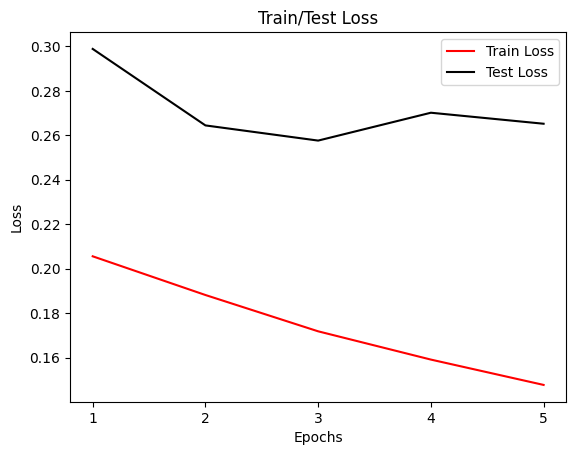

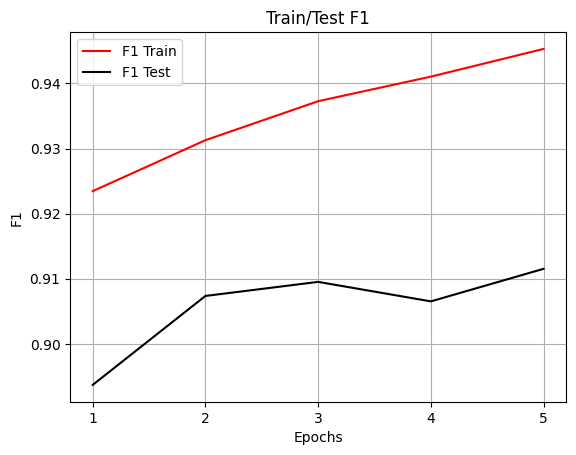

In [ ]:
# Fitteo y evaluacion de model 5 (Si desea guardar el modelo en .pth completar argumento file_name)
fit_eval(model_5,dataloader,epochs=5)

In [ ]:
# Probamos como clasifica con un elemento

test_features, test_labels = next(iter(dataloader['test']))

# item a usar k
k = 8
img_sample=test_features[k]

# ploteo la imagen
plt.imshow(img_sample.squeeze(), cmap='gray')
plt.show()

# Armar sample en formato que pueda procesar la cnn (batch_size, n_chanells, h, w)
samp_imp = img_sample.unsqueeze(0)
samp_img = img_sample.unsqueeze(0).to(device)
print('Shape imagen de entrada a red: ', samp_img.shape)

# Pasar sample al modelo
# model_5.cuda()
model_5.eval()
y_hat = model_5(samp_img)
print('Predición del modelo:')
print(y_hat.detach())
print()
print('Softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1).detach())
print()
print(f'El numero predicho es un {torch.argmax(y_hat, axis=1).item()}(label real es {test_labels[k]}) y corresponde a {labels_map[torch.argmax(y_hat, axis=1).item()]}')

**Conclusión 2.a.a:**

Las 5 arquitecturas responden muy bien al dataset de Fashion MNIST. Entre ellos hay diferencias mínimas pero la mejor performance promedio en las 5 epochs en test_loss y f1_test fue el modelo 5:

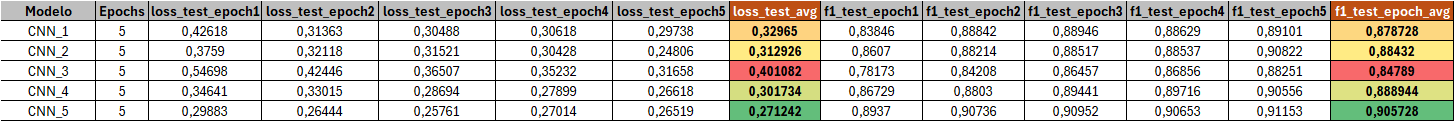

Arquitectura modelo 5:

1) Tres Conv Layer formada:
* Capa Convulucional(estrategia padding=same, kernel 5x5, stride=1)
* Capa No Lineal TanH
* Capa Pooling (estrategia Max, kernel 3x3, stride=2, padding=1)

2) Fully Connected compuesta por una capa lineal con 10 salidas una para cada clase

Por cuestiones de tiempos de resolución y comparación se entrenaron y evaluaron los modelos con 5 epochs pero sería una buena práctica aumentar este hiperparametro para ver como afecta a la performance del modelo.

Ahora, modificaremos la arquitectura del modelo 5, agregando capas de dropout y batch normalization con el objetivo de revisar si mejoras las metricas. Probaremos dos arqutecturas:

Arquitectura 1:

* Batch Normalization a salida de conv layers
* Agregado de capa no lineal ReLU entre batch normalization y dropout
* Dropout en primer conv layer de 0.3 y en las dos restantes 0.2


Arquitectura 2:

* Batch Normalization a salida de conv layers
*Agregado de capa no lineal Tanh entre batch normalization y dropout
* Dropout en primer conv layer de 0.5 y en segunda capa de 0.3

In [ ]:
class CNN_5_mod(torch.nn.Module):
    def __init__(self, in_channels=1, outputs=10): # el in_channels es 1 porque las imagenes son escala de grises y outputs es 10 porque tenemos 10 clases
        super().__init__()
        self.conv1 = conv_layer_3(in_channels, 16, k=5, pk=3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.dropout_1 = torch.nn.Dropout(0.3)

        self.conv2 = conv_layer_3(16, 32, k=5, pk=3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.dropout_2 = torch.nn.Dropout(0.2)

        self.conv3 = conv_layer_3(32, 64, k=5, pk=3)
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.dropout_3 = torch.nn.Dropout(0.2)

        self.fc = torch.nn.Linear(1024, outputs)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.nn.functional.relu(x) # Se aplica unicamente en forward ya que al no tener parametros entrenable no afecta a la cnn
        x = self.dropout_1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.nn.functional.relu(x) # Se aplica unicamente en forward ya que al no tener parametros entrenable no afecta a la cnn
        x = self.dropout_2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.nn.functional.relu(x) # Se aplica unicamente en forward ya que al no tener parametros entrenable no afecta a la cnn
        x = self.dropout_3(x)

        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        return x

In [ ]:
# Inicializamos CNN_5_mod (con Dropout en todas las capas convolucionales)
model_5_mod=CNN_5_mod()

In [ ]:
# Revisamos summary
summary(model_5_mod,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              Tanh-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
       BatchNorm2d-4           [-1, 16, 14, 14]              32
           Dropout-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]          12,832
              Tanh-7           [-1, 32, 14, 14]               0
         MaxPool2d-8             [-1, 32, 7, 7]               0
       BatchNorm2d-9             [-1, 32, 7, 7]              64
          Dropout-10             [-1, 32, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          51,264
             Tanh-12             [-1, 64, 7, 7]               0
        MaxPool2d-13             [-1, 64, 4, 4]               0
      BatchNorm2d-14             [-1, 6

loss0.36646 F1 0.86506: 100%|██████████| 157/157 [00:07<00:00, 20.33it/s]


Epoch 1/5 loss 0.46880 test_loss 0.36646 f1_train 0.82407 f1_test 0.86506


loss0.30895 F1 0.88736: 100%|██████████| 157/157 [00:07<00:00, 20.35it/s]


Epoch 2/5 loss 0.34400 test_loss 0.30895 f1_train 0.86974 f1_test 0.88736


loss0.28814 F1 0.89206: 100%|██████████| 157/157 [00:09<00:00, 16.81it/s]


Epoch 3/5 loss 0.31490 test_loss 0.28814 f1_train 0.88167 f1_test 0.89206


loss0.29011 F1 0.89106: 100%|██████████| 157/157 [00:09<00:00, 17.38it/s]


Epoch 4/5 loss 0.29319 test_loss 0.29011 f1_train 0.89073 f1_test 0.89106


loss0.28773 F1 0.89410: 100%|██████████| 157/157 [00:07<00:00, 20.10it/s]


Epoch 5/5 loss 0.28389 test_loss 0.28773 f1_train 0.89280 f1_test 0.89410
Model saved to /content/cnn_5_5pochs_dropout.0.3_0.3_0.2.pth


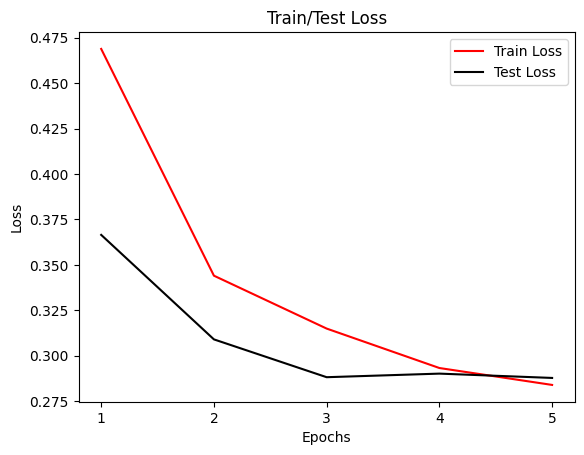

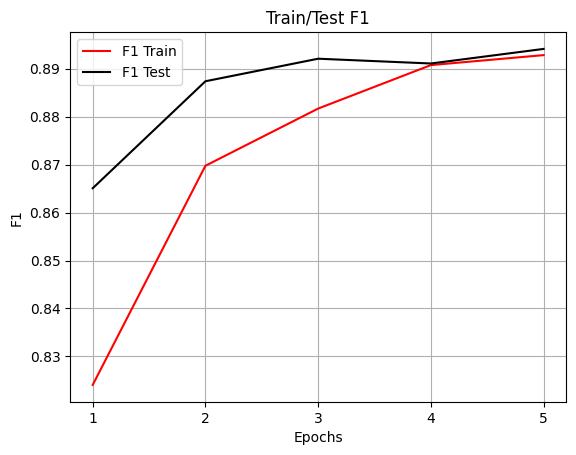

In [ ]:
# Fitteo y evaluacion de model_5_mod (Si desea guardar el modelo en .pth completar argumento file_name)
fit_eval(model_5_mod,dataloader,epochs=5)

In [ ]:
class CNN_5_mod_1(torch.nn.Module):
    def __init__(self, in_channels=1, outputs=10):
        super().__init__()
        self.conv1 = conv_layer_3(in_channels, 16, k=5, pk=3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.dropout_1 = torch.nn.Dropout(0.5)
        self.conv2 = conv_layer_3(16, 32, k=5, pk=3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.dropout_2 = torch.nn.Dropout(0.3)
        self.conv3 = conv_layer_3(32, 64, k=5, pk=3)
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.fc = torch.nn.Linear(1024, outputs)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.nn.functional.tanh(x) # Se aplica unicamente en forward ya que al no tener parametros entrenable no afecta a la cnn
        x = self.dropout_1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.nn.functional.tanh(x) # Se aplica unicamente en forward ya que al no tener parametros entrenable no afecta a la cnn
        x = self.dropout_2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.nn.functional.tanh(x) # Se aplica unicamente en forward ya que al no tener parametros entrenable no afecta a la cnn

        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        return x

In [ ]:
# Inicializamos CNN_5_mod_1 (con Dropout en las dos primeras capas convolucionales)
model_5_mod_1=CNN_5_mod_1()

In [ ]:
# Revisamos summary
summary(model_5_mod,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              Tanh-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
       BatchNorm2d-4           [-1, 16, 14, 14]              32
           Dropout-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]          12,832
              Tanh-7           [-1, 32, 14, 14]               0
         MaxPool2d-8             [-1, 32, 7, 7]               0
       BatchNorm2d-9             [-1, 32, 7, 7]              64
          Dropout-10             [-1, 32, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          51,264
             Tanh-12             [-1, 64, 7, 7]               0
        MaxPool2d-13             [-1, 64, 4, 4]               0
      BatchNorm2d-14             [-1, 6

loss0.39361 F1 0.85339: 100%|██████████| 157/157 [00:08<00:00, 19.16it/s]


Epoch 1/5 loss 0.48124 test_loss 0.39361 f1_train 0.81998 f1_test 0.85339


loss0.33761 F1 0.87548: 100%|██████████| 157/157 [00:09<00:00, 17.22it/s]


Epoch 2/5 loss 0.34720 test_loss 0.33761 f1_train 0.86941 f1_test 0.87548


loss0.33704 F1 0.87367: 100%|██████████| 157/157 [00:08<00:00, 18.87it/s]


Epoch 3/5 loss 0.31760 test_loss 0.33704 f1_train 0.88190 f1_test 0.87367


loss0.35103 F1 0.86996: 100%|██████████| 157/157 [00:12<00:00, 13.04it/s]


Epoch 4/5 loss 0.30687 test_loss 0.35103 f1_train 0.88663 f1_test 0.86996


loss0.29488 F1 0.88509: 100%|██████████| 157/157 [00:09<00:00, 17.21it/s]


Epoch 5/5 loss 0.29371 test_loss 0.29488 f1_train 0.89053 f1_test 0.88509
Model saved to /content/cnn_5_5pochs_dropout_0.5_0.3.pth


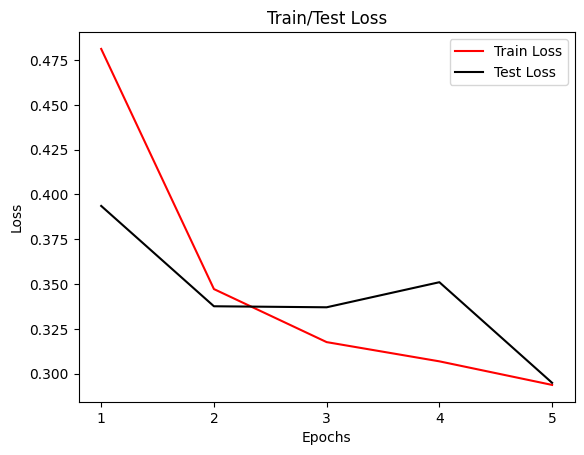

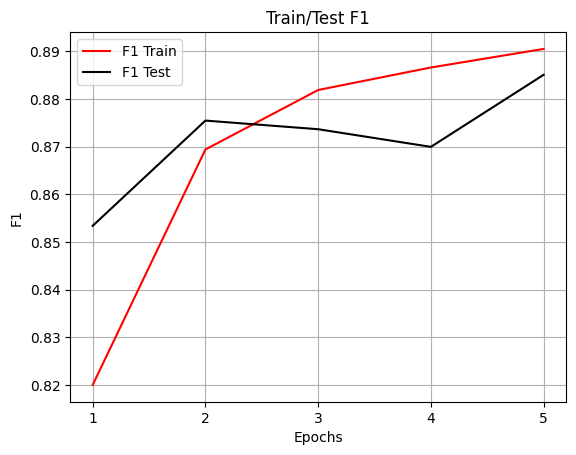

In [ ]:
# Fitteo y evaluacion de model_5_mod_1 (Si desea guardar el modelo en .pth completar argumento file_name)
fit_eval(model_5_mod_1,dataloader,epochs=5)

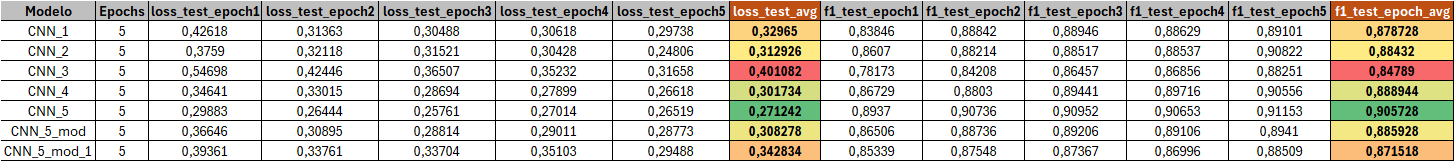

**Conclusion 2.a.b:**

Podemos observar que aún agregando capas de Dropout como batch normalization el modelo 5 original sigue siendo la mejor opción en 5 epochs. El análisis podría diferir en el caso de entrenar los modelos con mayor cantidad de epochs pero cuestiones de tiempos de resolución no se realizará pero seria una muy buena práctica hacerlo.

## Parte 2.b

Empleando el modelo entrenado y elegido por Ud. en el punto anterior, realice transfer learning para procesar las imágenes del dataset MNIST (los números) e identificar los números mayores o menores a 4,5.
Para el entrenamiento emplee solamente 20.000 muestras del set de entrenamiento y valide con el set de testeo. (al reducir el train set, mantenga equilibrada la distribución de las clases!!)

Pruebe 2 estrategias de transfer learning distintas (acorde a los visto en la teoría) y comente para cada una, cual debería funcionar mejor justificando su respuesta.


Compare los resultados finales y comente.

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset


# Definir las transformaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar el dataset MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Balancear las clases en el subset de entrenamiento
labels = train_dataset.targets.numpy()
train_idx = []
for label in range(10):
    indices = np.where(labels == label)[0]
    subset = indices[:2000]  # Tomamos 2000 muestras de cada clase
    train_idx.extend(subset)

train_subset = Subset(train_dataset, train_idx)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:09<00:00, 994129.02it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 159917.64it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1507075.56it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4879746.10it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



**Estrategia 1:**

* Congelamiento de todas las capas convolucionales
* Modificación y ajuste de capa final fully connected

In [ ]:
# Arquitectura CNN_5. Este codigo fue generado anteriormente pero se coloca para tener la estructura de red transfer learning más visual

class CNN_5(torch.nn.Module):
  def __init__(self,in_channels=1, outputs=10): # el in_channels es 1 porque las imagenes son escala de grises y outputs es 10 porque tenemos 10 clases
    super().__init__()
    self.conv1=conv_layer_3(in_channels,16, k=5,pk=3)
    self.conv1_out = None
    self.conv2=conv_layer_3(16,32,k=5,pk=3)
    self.conv2_out = None
    self.conv3=conv_layer_3(32,64,k=5,pk=3)
    self.conv3_out = None
    self.fc=torch.nn.Linear(1024,outputs)


  def forward(self,x):
    self.conv1_out=self.conv1(x)
    self.conv2_out=self.conv2(self.conv1_out)
    self.conv3_out=self.conv3(self.conv2_out)
    x=self.conv3_out.view(self.conv3_out.shape[0],-1)
    x=self.fc(x)

    return x

In [ ]:
# Cargar el modelo preentrenado
model_tl = CNN_5()
model_tl.load_state_dict(torch.load('/content/cnn_5_5epochs.pth')) # Subir a /coontet modelo preentrenado "cnn_5_epochs.pth" o completar file_name con nombre "cnn_5_epochs.pth" en fit_eval del modelo 5, esto entrenara un nuevo modelo y lo renombrará como cnn_5_epochs.pth y se utilizará como modelo preentrenado)

# Congelar las capas convolucionales
for param in model_tl.conv1.parameters():
    param.requires_grad = False
for param in model_tl.conv2.parameters():
    param.requires_grad = False
for param in model_tl.conv3.parameters():
    param.requires_grad = False

# Reemplazamos la última capa completamente conectada
num_features = model_tl.fc.in_features
model_tl.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

# Definimimos criterio de pérdida y optimizador
criterion = nn.BCELoss()
optimizer = optim.Adam(model_tl.fc.parameters(), lr=0.001)

# Entrenamiento del modelo ajustado
for epoch in range(5):
    model_tl.train()
    for inputs, labels in train_loader:
        labels = (labels >= 5).float().unsqueeze(1)  # Convertir a binario Clase 1: [0,1,2,3,4] Clase 2: [5,6,7,8,9]
        optimizer.zero_grad()
        optimizer.zero_grad()
        outputs = model_tl(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluación
    model_tl.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            labels = (labels >= 5).float().unsqueeze(1)
            outputs = model_tl(inputs)
            predicted = (outputs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch+1}, Accuracy: {100 * correct / total:.2f}%')

Epoch 1, Accuracy: 91.25%
Epoch 2, Accuracy: 94.11%
Epoch 3, Accuracy: 95.11%
Epoch 4, Accuracy: 95.54%
Epoch 5, Accuracy: 95.72%


**Estrategia 2:**

* Congelamiento de las 2 primeras capas convolucionales
* Modificación capa de convolución 3 y creación de una 4 capa convolucional
*  Modificación y ajuste de capa final fully connected

In [ ]:
# Cargar el modelo preentrenado
model_tl_1 = CNN_5()
model_tl_1.load_state_dict(torch.load('/content/cnn_5_5epochs.pth'))

# Congelar las primeras dos capas convolucionales
for param in model_tl_1.conv1.parameters():
    param.requires_grad = False
for param in model_tl_1.conv2.parameters():
    param.requires_grad = False

# Modifiación de conv3
model_tl_1.conv3 = nn.Sequential(
    nn.Conv2d(32, 64, kernel_size=5, padding=2),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(0.2)
)

# Creación de conv4
model_tl_1.conv4 = nn.Sequential(
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2)
)

# Adaptamos la última capa completamente conectada
model_tl_1.fc = nn.Sequential(
    nn.Linear(1152, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

class CNN_5_Modified(CNN_5):
    def __init__(self, model_tl_1):
        super().__init__()
        self.conv1 = model_tl_1.conv1
        self.conv2 = model_tl_1.conv2
        self.conv3 = model_tl_1.conv3
        self.conv4 = model_tl_1.conv4
        self.fc = model_tl_1.fc

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        if self.conv4:
            x = self.conv4(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

model_tl_1_modified = CNN_5_Modified(model_tl_1)

# Definimimos criterio de pérdida y optimizador
criterion = nn.BCELoss()
optimizer = optim.Adam(model_tl_1_modified.parameters(), lr=0.001)

# Entrenamiento del modelo ajustado
for epoch in range(5):
    model_tl_1_modified.train()
    for inputs, labels in train_loader:
        labels = (labels >= 5).float().unsqueeze(1)  # Convertir a binario Clase 1: [0,1,2,3,4] Clase 2: [5,6,7,8,9]
        optimizer.zero_grad()
        outputs = model_tl_1_modified(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluación
    model_tl_1_modified.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            labels = (labels >= 5).float().unsqueeze(1)
            outputs = model_tl_1_modified(inputs)
            predicted = (outputs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch+1}, Accuracy: {100 * correct / total:.2f}%')

Epoch 1, Accuracy: 96.67%
Epoch 2, Accuracy: 97.83%
Epoch 3, Accuracy: 98.17%
Epoch 4, Accuracy: 97.04%
Epoch 5, Accuracy: 98.35%


**Conclusión 2.b:**

Podemos observar que en ambas estrategias de transfer learning los modelos tienen métrica de accuuracy muy buenas para predecir números mayores 4.5. Se puede observar que en la 2° estretegia la metrica mejora considerablemente esto se debe a que se ha modificado la 3 capa convolucional agregando batch normalization y dropout como tambien agregando una 4 capa convolucional (batch normalization y dropout). En ambas estrategias, se agrega un segunda capa lineal a la fully connected para mejorar el output.